# **Projet Spam Classifier Kaëlig & Pierre**



# Modèle à la mano 🧞




Importation et téléchargement des différentes bibliotèques :

In [1]:
import time
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer
import re
import math
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score)
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn import metrics

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download("punkt")

stop_words = set(stopwords.words('english'))#creation des variable vanant de la librairie NTK
ps = PorterStemmer()
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Creation des fonctions définissant les "caractéristiques" des spams et hams

In [2]:
def mot(a): #compte le nombre de mot par message
    count=0
    for i in range(len(a)):
        if a[i] ==' ' and a[(i-1)]!=' ':
            count+=1
        if a[len(a)-1]!=' ' and i ==(len(a)-1):
            count+=1
    return count

def caract_spec(a):#compte le nombre de caractère spéciaux par message
    b={'&','é','"',"'",'-','_',')','=','~','#','{','[','|','`',"^","@","]","}","°","+",",",";",":","!","?",".","/","§","*","$","£","%","µ"}
    count=0
    for i in a:
        if i in b:
            count+=1
    return count

def maj(a):#compte le nombre de majuscule par message
    b=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    count=0
    for i in a:
        if i in b:
            count+=1
    return count

def numeros_tel(a):#regarde si il y a la présence de 3 numéros ou plus à la suite
    count=0
    for i in a:
        if i.isnumeric():
            count+=1
            if count==3:
                return True
        else :
            count=0
    return False

def lien(a):#regarde si il y a la présence de liens
    b=['http://','https://','www']
    for i in b:
        if i in a:
            return True
    else:
        return False

def argent(a):#regarde si il y a la présence de symbole monétaire
    b=['£','$','€']
    for i in b:
        if i in a:
            return True
    else:
        return False

def decoupage_mot(a,formatage=False,stemmer=None,tokenize=None):
    b=['&','"',"'",'-','_',')','=','~','#','{','[','|','`',"^","@","]","}","°","+",",",";",":","!","?",".","/","§","*","$","£","%","µ"]

    if isinstance(a, list):
        a=" ".join(a)
    if isinstance(a, str) and formatage is False :
        c=a.split()
    if isinstance(a, str) and formatage is True and tokenize ==None:
        for i in b:
            a=a.replace(i,' ')
        a=a.lower()
        c=a.split()
    if tokenize:
        c=word_tokenize(a)
    if stemmer:
        c = [stemmer.stem(word) for word in c]
    return c
#Création d'une fonction qui me permet de tokeniser et de lemmatizer mes mots

def filtre_stopwords(a):
    mot2 = decoupage_mot(a,stemmer=ps,tokenize=1)
    filtered_words = [mot for mot in mot2 if mot.lower() not in stop_words]
    return ' '.join(filtered_words)
#création d'une fonction qui appique uj filtre stopwords sur une colonne (non utiliser car diminue les perfomance ou ne change rien)

Création de fonction permettant la création de n-gramme et de bag of words

In [3]:
#premiere façons est de compter le nombre d'occurence de chaque mot dans l'entiereté des documents pour déterminer les plus utiliser
#ce qui permet de determiner des mots 'caractéristique' pour les 2 groupe de document
def comptage_occurence(df,colonne,nb=None,stemmer=None):
    a=list(df[colonne].values.tolist())
    if stemmer:
        a=decoupage_mot(a,formatage=True,stemmer=ps,tokenize=1)
    else:
        a=decoupage_mot(a,formatage=True,tokenize=1)

    df_a=pd.DataFrame(data=a)
    dico_a = df_a[0].value_counts().to_dict()

    df_a=pd.DataFrame(list(dico_a.items()), columns=['Mot', 'Occurrences'])
    df_a=df_a.sort_values(by=['Occurrences'],ascending=False)
    if nb:
        df_a=df_a.head(nb)
    return df_a

#Créations d'une fonction TF-IDF pour donner un 'poid' à chaque mot et rajouter des mots important à integrer dans le bag of words
def TF_IDF(df, group_column='sorte', weight_ratio=None):
    def computeTF(df, group_column):# Permet de calculer TF
        df['nb mot'] = df['contenus'].apply(mot)

        df=df.set_index('contenus')
        df_sorte=df['sorte']
        term_columns = df.columns[1:]
        df = df[term_columns].div(df.loc[:, 'nb mot'], axis=0)

        df = df.drop(labels='nb mot', axis=1)
        df=pd.concat([df,df_sorte],axis=1)
        df=df.reset_index()
        return df

    def computeIDF(df):#permet de calculer IDF
        if 'contenus' in df.columns:
            df = df.drop(labels=['contenus'], axis=1)
        if group_column in df.columns:
            df = df.drop(labels=[group_column], axis=1)
        N = len(df)
        df_gt_zero = df.applymap(lambda x: x > 0)
        df_df = df_gt_zero.sum()

        idfDict = df_df.apply(lambda df: math.log10(N / (df + 1)))
        return idfDict.to_dict()

    def computeTFIDF(df, idfs, weight_ratio, group_column='sorte'):#Combine TF et IDF pour avoir le poid final TF-IDF
        count=0
        colonne_a_exclure='contenus'
        if weight_ratio:
            for i in df[group_column]:
                if i == 'ham':
                    count+=1
            ham_ratio = count / len(df)
            print(f"ham_ratio ={ham_ratio}")
            spam_ratio = 1 - ham_ratio
            print(f"spam_ratio ={spam_ratio}")
            df[group_column] = df[group_column].apply(lambda x: ham_ratio if x == 'ham' else spam_ratio)
            df[df.columns.difference([colonne_a_exclure])] = df[df.columns.difference([colonne_a_exclure])].apply(lambda x: x*df[group_column])

        for word, val in idfs.items():
            df[word] = val * df[word]
        return df
    df_copy = df.copy()
    df_copy1 = df.copy()
    df_computeTF = computeTF(df_copy,group_column)
    idfs = computeIDF(df_copy1)
    df_computeTF1=df_computeTF.copy()
    resultat_tf_IDF = computeTFIDF(df_computeTF1, idfs, weight_ratio, group_column)
    return resultat_tf_IDF

#Création d'une fonction qui merge mes differentes selections de mot pour evitez les doublons de mots selectionné
#Va en général prendre mes mots pour spam mes mots pour ham et l'entiereté des mots de mon df2 pour créer un tables ne contenant que les
#mots présents dans df1 et non dans df2 en rajoutant leurs nombres d'occurences dans df2_all au cas où je veut comparer les stats
#(puisque les groupes ont un nombre déséquilibrés)
def selection_merge(df1,df2,df2_all,colonne,colonne2):
    df = pd.merge(df1, df2, how='left',on=[colonne], indicator=True).query("_merge == 'left_only'").drop('_merge', axis=1)
    df.drop(labels=f"{colonne2}_y",axis=1,inplace=True)
    df = pd.merge(df, df2_all, how='outer',on=[colonne])

    df.dropna(subset=f"{colonne2}_x",inplace=True)
    df.drop
    return df

#Création d'une fonction qui pour chaque mot dans le bag of words permet de compter le nombre d'occurence du mot par message et créer une
#colonne par mot du bags of word avec chaque ligne son nombre d'occurence par message (utiliser pour le TF-DIF)
def mot_to_colonne_count(df_liste_mot, colonne1, dataframe, colonne2):
    dataframe_copy = dataframe.copy()

    mots_a_rechercher = set()
    for i in df_liste_mot[colonne1]:
        if isinstance(i, str):
            mots_a_rechercher.add(i)
        elif isinstance(i, tuple):
            mots_a_rechercher.add(' '.join(i))

    dataframe_copy[colonne2] = dataframe_copy[colonne2].apply(lambda x: ' '.join(decoupage_mot(x, formatage=True, stemmer=ps, tokenize=1)))

    def count_occurrences(text, word):
        return text.count(word)

    for word in mots_a_rechercher:
        dataframe_copy[word] = dataframe_copy[colonne2].apply(lambda x: count_occurrences(x, word))

    return dataframe_copy

  #Création d'une fonction qui créer un tableau de boulot avec pour chaque ligne un message et chaque colonne un mot (avec True si il sont
  #présent dans le message et False sinon)
def mot_to_colonne(df_liste_mot, colonne1, dataframe, colonne2):
    if colonne1 == 'column':
        mots_a_rechercher = set(str(x) for x in df_liste_mot.columns)
    elif colonne1 != 'column':
        mots_a_rechercher = set(df_liste_mot[colonne1].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else x))

    dataframe_copy = dataframe.copy()
    dataframe_copy[colonne2] = dataframe_copy[colonne2].apply(lambda x: ' '.join(decoupage_mot(x, formatage=True, stemmer=ps, tokenize=1)))

    temp_df = {mot: dataframe_copy[colonne2].str.contains(fr'\b{re.escape(str(mot))}\b', case=False, regex=True) for mot in mots_a_rechercher}

    dataframe_copy = pd.concat([dataframe_copy, pd.DataFrame(temp_df)], axis=1)
    return dataframe_copy

#Création d'une fonction qui ajoute dans une liste tout les n-gramme de mes messages (sous formes de tuple) avec b etant mon n et a mon message
def relation(a,b):
    count=0
    c=[]
    for i in range(len(a)-(b-1)):
        c.append([])
    for i in range(len(a)):
        if i>=(b-1):
            for j in range((b-1),-1,-1):
                c[count].append(a[i-j])
            count+=1
    return c

#Créer une fonction qui recupére ma liste de n-gramme et qui fait un dataframe avec mes n-gramme et leur nombre d'occurence dans l'entiereté
#du corpus, et enfin choisit les nb_head qui ont le plus d'occurence
def tableau_n_gramme(df,colonne,nb_n,nb_head=None,stemmer=None):
    liste1, liste2 =[],[]
    dico={}
    df_copy=df.copy()
    if stemmer:
        #df_copy[colonne] = df_copy[colonne].apply(filtre_stopwords)
        df_copy['Contenus_mot']=df_copy[colonne].apply(lambda x: decoupage_mot(x, formatage=True,stemmer=ps,tokenize=1))
    else:
        #df_copy[colonne] = df_copy[colonne].apply(filtre_stopwords)
        df_copy['Contenus_mot']=df_copy[colonne].apply(lambda x: decoupage_mot(x, formatage=True,tokenize=1))

    liste1.extend(df_copy['Contenus_mot'].apply(lambda x: relation(x,nb_n)).tolist())
    for i in liste1:
        for j in i:
            liste2.append(j)

    for element in liste2:
        key = tuple(element)
        if key in dico:
            dico[key]+=1
        else:
            dico[key]=1
    df_final=pd.DataFrame(list(dico.items()))
    df_final=df_final.sort_values(by=1,ascending=False)
    if nb_head:
        df_final=df_final.head(nb_head)
    return df_final


Maintenant que mes fonctions sont posé je vais commencer par nettoyer mes données

In [40]:
Spam = pd.read_csv("https://raw.githubusercontent.com/remijul/dataset/master/SMSSpamCollection", delimiter='\t', header=None)
Spam_copy=Spam.copy()#créer un dataframme de mes données

Spam1=Spam_copy.drop_duplicates()#élimine mes lignes en plusieurs exemplaires

Spam1=Spam1.rename(columns={0:'sorte'})#nomme mes 2 colonnes
Spam1=Spam1.rename(columns={1:'contenus'})

Spam1['contenus']=Spam1['contenus'].apply(lambda x: x.replace('&lt;', 'name1'))
Spam1['contenus']=Spam1['contenus'].apply(lambda x: x.replace('#&gt;', 'name2'))#renome une occurence qui pourrait polluer mes données

only_spam=Spam1[Spam1.sorte.str.contains('spam')]#Création d'un dataframmes regroupant tout les documents d'un groupe
only_ham=Spam1[Spam1.sorte.str.contains('ham')]



In [5]:
only_spam1=only_spam.copy()
only_ham1=only_ham.copy()

only_spam1['nb maj']=only_spam1['contenus'].apply(maj)
only_spam1['nb charact']=only_spam1['contenus'].apply(lambda x: len(str(x)))
only_spam1['nb carac spec']=only_spam1['contenus'].apply(caract_spec)
only_spam1['nb mot']=only_spam1['contenus'].apply(lambda x: mot(x))
only_spam1['ratio charact/mot']=only_spam1['nb charact']/only_spam1['nb mot']

only_ham1['nb maj']=only_ham1['contenus'].apply(maj)
only_ham1['nb charact']=only_ham1['contenus'].apply(lambda x: len(str(x)))
only_ham1['nb carac spec']=only_ham1['contenus'].apply(caract_spec)
only_ham1['nb mot']=only_ham1['contenus'].apply(lambda x: mot(x))
only_ham1['ratio charact/mot']=only_ham1['nb charact']/only_ham1['nb mot']#observation des caractéristique définis pour voir si ellesont réellement un impact

print(only_spam1.describe())
print(only_ham1.describe())

           nb maj  nb charact  nb carac spec      nb mot  ratio charact/mot
count  653.000000  653.000000     653.000000  653.000000         653.000000
mean    15.267994  137.704441       5.926493   23.739663           5.930063
std     12.647904   29.821348       3.457115    5.931064           1.023861
min      0.000000   13.000000       0.000000    2.000000           4.250000
25%      7.000000  132.000000       3.000000   22.000000           5.360000
50%     13.000000  148.000000       6.000000   25.000000           5.814815
75%     21.000000  157.000000       8.000000   28.000000           6.333333
max    128.000000  223.000000      25.000000   35.000000          18.166667
            nb maj   nb charact  nb carac spec       nb mot  ratio charact/mot
count  4516.000000  4516.000000    4516.000000  4516.000000        4516.000000
mean      3.970106    70.968999       3.522808    14.240478           5.048662
std      10.939165    56.815693       3.710112    11.176752           1.094951


Maintenant commence a créer mon bag of words :

In [41]:
#1/ Fait la liste des mots les plus vues dans mon corpus

count_mot_spam_max=comptage_occurence(only_spam,'contenus',700,stemmer=1)#Fait ma liste des 700 mots les plus utilisé dans les spams
count_mot_spam=comptage_occurence(only_spam,'contenus',stemmer=1)#Fait ma liste de tout les mots utilisé dans les spams

count_mot_ham_max=comptage_occurence(only_ham,'contenus',300,stemmer=1)#Fait ma liste des 700 mots les plus utilisé dans les hams
count_mot_ham=comptage_occurence(only_ham,'contenus',stemmer=1)#Fait ma liste de tout les mots utilisé dans les hams

selection_spam_mot=selection_merge(count_mot_spam_max,count_mot_ham_max,count_mot_ham,'Mot','Occurrences')#merge mes liste de mots pour eliminer mes redits
selection_ham_mot=selection_merge(count_mot_ham_max,count_mot_spam_max,count_mot_spam,'Mot','Occurrences')

In [42]:
#2/ Utilisation du TF-IDF
  #1/Preparation des variables pour le TF-IDF
count_mot=comptage_occurence(Spam1,'contenus',stemmer=1)#fait un dico contenant tout les mots du corpus avec leur nombre d'occurences
df_final_tot_count=mot_to_colonne_count(count_mot,'Mot',Spam1,'contenus')#place ensuite ces mots dans un tableau avec leur nombre d'occurence par message
  #2/Application du TF-IDF
df_total_mot_TF_IDF=TF_IDF(df_final_tot_count)#Fait mon df contenant le poind des mots pour chaque messages
if 'contenus' in df_total_mot_TF_IDF.columns:
    df_total_mot_TF_IDF=df_total_mot_TF_IDF.drop('contenus',axis=1)
if 'sorte' in df_total_mot_TF_IDF.columns:
    df_total_mot_TF_IDF=df_total_mot_TF_IDF.set_index('sorte')
  #3/Filtrage des mots grâce au TF-TDF
seuil_tfidf_max = 1 #decide du poid minimum qu'un mot doit avoir dans au moins un messages pour etre sélectionner
masque_filtrage =  df_total_mot_TF_IDF > seuil_tfidf_max #créer un masque avec le seuil
mots_filtrés = df_total_mot_TF_IDF.loc[:, masque_filtrage.any(axis=0)]#applique le masque

for mot1 in selection_ham_mot.Mot:#elimine mes redits entre mes mots du TF-IDF et ma liste des mots avec le plus d'occurence
    if mot1 in mots_filtrés.columns:
        mots_filtrés=mots_filtrés.drop(labels=[mot1],axis=1)

for mot2 in selection_spam_mot.Mot:
    if mot2 in mots_filtrés.columns:
        mots_filtrés=mots_filtrés.drop(labels=[mot2],axis=1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
<ipython-input-3-3948e7d5dc55>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_copy[word] = dataframe_copy[colonne2].apply(lambda x: count_occurrences(x, word))
<ipython-input-3-3948e7d5dc55>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_copy[word] = dataframe_copy[colonne2].apply(lambda x: count_occurrences(x, word))
<ipython-input-3-3948e7d5dc55>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

Maintenant nous allons créer les listes de n-grammes pour n=2,3 et 4

In [ ]:
#1/Création des listes de n-grammes les plus utilisé
relation_mot_spam_max2=tableau_n_gramme(only_spam,'contenus',2,400,stemmer=1)
relation_mot_ham_max2=tableau_n_gramme(only_ham,'contenus',2,400,stemmer=1)#Création 2-gramme pour spam et ham avec les 200 premiers mots

relation_mot_spam2=tableau_n_gramme(only_spam,'contenus',2,stemmer=1)
relation_mot_ham2=tableau_n_gramme(only_ham,'contenus',2,stemmer=1)#Création 2-gramme pour spam et ham avec tout les mots

relation_mot_spam_max3=tableau_n_gramme(only_spam,'contenus',3,400,stemmer=1)
relation_mot_ham_max3=tableau_n_gramme(only_ham,'contenus',3,400,stemmer=1)#Création 3-gramme pour spam et ham avec les 200 premiers mots

relation_mot_spam3=tableau_n_gramme(only_spam,'contenus',3,stemmer=1)
relation_mot_ham3=tableau_n_gramme(only_ham,'contenus',3,stemmer=1)#Création 3-gramme pour spam et ham avec tout les mots

relation_mot_spam_max4=tableau_n_gramme(only_spam,'contenus',4,400,stemmer=1)
relation_mot_ham_max4=tableau_n_gramme(only_ham,'contenus',4,400,stemmer=1)#Création 4-gramme pour spam et ham avec les 200 premiers mots

relation_mot_spam4=tableau_n_gramme(only_spam,'contenus',4,stemmer=1)
relation_mot_ham4=tableau_n_gramme(only_ham,'contenus',4,stemmer=1)#Création 4-gramme pour spam et ham avec tout les mots

#2/Mergage de ces liste de n-grammes pour éliminer les redits
selection_spam_2_gramm=selection_merge(relation_mot_spam_max2,relation_mot_ham_max2,relation_mot_ham2,0,1)
selection_ham_2_gramm=selection_merge(relation_mot_ham_max2,relation_mot_spam_max2,relation_mot_spam2,0,1)

selection_spam_3_gramm=selection_merge(relation_mot_spam_max3,relation_mot_ham_max3,relation_mot_ham3,0,1)
selection_ham_3_gramm=selection_merge(relation_mot_ham_max3,relation_mot_spam_max3,relation_mot_spam3,0,1)

selection_spam_4_gramm=selection_merge(relation_mot_spam_max4,relation_mot_ham_max4,relation_mot_ham4,0,1)
selection_ham_4_gramm=selection_merge(relation_mot_ham_max4,relation_mot_spam_max4,relation_mot_spam4,0,1)

Maintenant que mon bag of words et mes n-grammes sont fait il ne me reste plus qu'a construire le modele de machine learning :

In [51]:
#1/ je commence par créer une fonction regroupant toute mes étapes de préprocessing
def creation_colonnes(df):
    start = time.time()
    #Verification our chaque message si les mots du bag of words et n-grammes sont présent dedans en faisant un tableau de booléens
    df=mot_to_colonne(mots_filtrés,'column',df,'contenus')
    df=mot_to_colonne(selection_spam_mot,'Mot',df,'contenus')
    df=mot_to_colonne(selection_ham_mot,'Mot',df,'contenus')
    df=mot_to_colonne(selection_spam_2_gramm,0,df,'contenus')
    df=mot_to_colonne(selection_ham_2_gramm,0,df,'contenus')
    df=mot_to_colonne(selection_spam_3_gramm,0,df,'contenus')
    df=mot_to_colonne(selection_ham_3_gramm,0,df,'contenus')
    df=mot_to_colonne(selection_spam_4_gramm,0,df,'contenus')
    df=mot_to_colonne(selection_ham_4_gramm,0,df,'contenus')

    #ajoute des colonnes de booléens pour mes caractéristiques
    df['nb maj']=df['contenus'].apply(maj)
    df['num_tel']=df['contenus'].apply(numeros_tel)
    df['lien']=df['contenus'].apply(lien)
    df['argent']=df['contenus'].apply(argent)
    df['nb charact']=df['contenus'].apply(lambda x: len(str(x)))
    df['nb carac spec']=df['contenus'].apply(caract_spec)
    if 'nb mot' in df.columns:
        df=df.drop(labels='nb mot',axis=1)

    #Grace a la fonction describe() sur chacun de mes groupes je peut determiner un points qui separe mes données assez facilement en 2 groupe
    #avec False et True contenant la majorité d'un des 2 groupe
    df['nb mot']=df['contenus'].apply(lambda x: mot(x))
    df['ratio charact/mot']=df['nb charact']/df['nb mot']
    df['nb maj']=df['nb maj'].apply(lambda x: True if x>25 else False)
    df['nb charact']=df['nb charact'].apply(lambda x: True if x>95 else False)
    df['nb mot']=df['nb mot'].apply(lambda x: True if x>20 else False)
    df['nb carac spec']=df['nb carac spec'].apply(lambda x: True if x>4 else False)

    #ajoute grace à NLTK un analyseur de sentiment pour les messages
    df['sentiment']=df['contenus'].apply(lambda texte: sia.polarity_scores(texte)['compound'])

    df=df.drop(labels=['contenus'],axis=1)
    print(f'{time.time() - start:.2f}s')
    return df


In [52]:
#2/ Création de la pipeline
svc = SVC(kernel='linear',C=1)
encod = Pipeline(steps=[('words', FunctionTransformer(creation_colonnes))])
preprocessor = ColumnTransformer(transformers=[('encod',encod, ['contenus'])])
model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', svc)])

In [53]:
#3/ Determination de x et y avec y mes données pour predire et y mon but de prédiction
y= Spam1.iloc[:,0]
X = Spam1.drop(labels=['sorte'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=Spam1['sorte'])

In [54]:
#4/ Entrainement du modèle
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

43.32s
11.59s


In [55]:
#5/Analyse des résultats
y_scores = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores ,pos_label='spam')
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
recall=recall_score(y_pred,y_test,pos_label='spam')

print(confusion_matrix(y_test, y_pred))
print("AUC: ", metrics.auc(fpr, tpr))
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("recall:",recall)


11.80s
[[900   3]
 [  6 125]]
AUC:  0.9986896942338093
Accuracy: 0.9912959381044487
F1 Score: 0.9913391304309056
recall: 0.9765625


In [56]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(model, X, y, scoring=scoring, cv=5)#test des performances

print("Cross-Validation Results:")
print("Accuracy:", np.mean(cv_results['test_accuracy']))
print("Precision:", np.mean(cv_results['test_precision_macro']))
print("Recall:", np.mean(cv_results['test_recall_macro']))
print("F1 Score:", np.mean(cv_results['test_f1_macro']))
print(cv_results)

44.64s
11.82s
43.73s
12.53s
44.12s
11.56s
42.83s
11.00s
43.87s
11.60s
Cross-Validation Results:
Accuracy: 0.9872321701079091
Precision: 0.9836440860553713
Recall: 0.9579910162900018
F1 Score: 0.9702665106814724
{'fit_time': array([47.37216187, 46.50489855, 46.59828997, 45.79621506, 46.6190412 ]), 'score_time': array([12.20236397, 12.93250108, 11.92367983, 11.54843855, 12.00205255]), 'test_accuracy': array([0.98839458, 0.9893617 , 0.98355899, 0.98452611, 0.99031946]), 'test_precision_macro': array([0.98632082, 0.98051187, 0.97647936, 0.98394637, 0.99096201]), 'test_recall_macro': array([0.96043227, 0.9710676 , 0.94816684, 0.94545747, 0.96483091]), 'test_f1_macro': array([0.97288651, 0.97572412, 0.96171997, 0.96359956, 0.97740239])}


In [15]:
svc=SVC()
from sklearn.model_selection import GridSearchCV
parameters = {'classifier__kernel':['linear','rbf','poly'],'classifier__C':[0.2,0.5,0.8,1]}#Determination des meilleurs parametre

grid = GridSearchCV(model, parameters, scoring='recall', cv = 5, n_jobs =-1, verbose = 1)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
recall = recall_score(y_test, y_pred, pos_label='spam')

accuracy = accuracy_score(y_pred, y_test)

print(grid.best_params_)
print("CV score - recall:", grid.best_score_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


57.80s
16.04s
{'classifier__C': 0.2, 'classifier__kernel': 'linear'}
CV score - recall: nan


Création d'une API (avec seulement le modèle ci dessus, dus au manque d'une pipeline du second )

Separation de la partie création des variables contenant les listes de mots a vérifier ( pour alleger le temps de calcul pour la préparation du modéle ) elle seront stockés dans un csv pour être appelée dans un autre script :

In [16]:
chemin_fichier_csv = 'mots_filtrés.csv'
chemin_fichier_csv1 = 'selection_spam_mot.csv'
chemin_fichier_csv2 = 'selection_ham_mot.csv'
chemin_fichier_csv3 = 'selection_spam_2_gramm.csv'
chemin_fichier_csv4 = 'selection_ham_2_gramm.csv'
chemin_fichier_csv5 = 'selection_spam_3_gramm.csv'
chemin_fichier_csv6 = 'selection_ham_3_gramm.csv'
chemin_fichier_csv7 = 'selection_spam_4_gramm.csv'
chemin_fichier_csv8 = 'selection_ham_4_gramm.csv'
chemin_fichier_csv9 = 'Spam.csv'

selection_spam_mot.to_csv(chemin_fichier_csv1, index=False)
mots_filtrés.to_csv(chemin_fichier_csv, index=False)
selection_ham_mot.to_csv(chemin_fichier_csv2, index=False)
selection_spam_2_gramm.to_csv(chemin_fichier_csv3, index=False)
selection_ham_2_gramm.to_csv(chemin_fichier_csv4, index=False)
selection_spam_3_gramm.to_csv(chemin_fichier_csv5, index=False)
selection_ham_3_gramm.to_csv(chemin_fichier_csv6, index=False)
selection_spam_4_gramm.to_csv(chemin_fichier_csv7, index=False)
selection_ham_4_gramm.to_csv(chemin_fichier_csv8, index=False)
Spam1.to_csv(chemin_fichier_csv9, index=False)

In [17]:
#appel des csv contenant mes variables
import pickle

mots_filtrés = pd.read_csv("mots_filtrés.csv")
selection_spam_mot = pd.read_csv("selection_spam_mot.csv")
selection_ham_mot = pd.read_csv("selection_ham_mot.csv")
selection_spam_2_gramm = pd.read_csv("selection_spam_2_gramm.csv")
selection_ham_2_gramm = pd.read_csv("selection_ham_2_gramm.csv")
selection_spam_3_gramm = pd.read_csv("selection_spam_3_gramm.csv")
selection_ham_3_gramm = pd.read_csv("selection_ham_3_gramm.csv")
selection_spam_4_gramm = pd.read_csv("selection_spam_4_gramm.csv")
selection_ham_4_gramm = pd.read_csv("selection_ham_4_gramm.csv")
Spam1= pd.read_csv("Spam.csv")

#redit du code précedent mais qui est cette fois separé dans un autre script python
def creation_colonnes(df):
    df=mot_to_colonne(mots_filtrés,'column',df,'contenus')
    df=mot_to_colonne(selection_spam_mot,'Mot',df,'contenus')
    df=mot_to_colonne(selection_ham_mot,'Mot',df,'contenus')
    df=mot_to_colonne(selection_spam_2_gramm,'0',df,'contenus')
    df=mot_to_colonne(selection_ham_2_gramm,'0',df,'contenus')
    df=mot_to_colonne(selection_spam_3_gramm,'0',df,'contenus')
    df=mot_to_colonne(selection_ham_3_gramm,'0',df,'contenus')
    df=mot_to_colonne(selection_spam_4_gramm,'0',df,'contenus')
    df=mot_to_colonne(selection_ham_4_gramm,'0',df,'contenus')

    df['nb maj']=df['contenus'].apply(maj)
    df['num_tel']=df['contenus'].apply(numeros_tel)
    df['lien']=df['contenus'].apply(lien)
    df['argent']=df['contenus'].apply(argent)
    df['nb charact']=df['contenus'].apply(lambda x: len(str(x)))
    df['nb carac spec']=df['contenus'].apply(caract_spec)
    if 'nb mot' in df.columns:
        df=df.drop(labels='nb mot',axis=1)
    df['nb mot']=df['contenus'].apply(lambda x: mot(x))
    df['ratio charact/mot']=df['nb charact']/df['nb mot']
    df['nb maj']=df['nb maj'].apply(lambda x: True if x>25 else False)
    df['nb charact']=df['nb charact'].apply(lambda x: True if x>95 else False)
    df['nb mot']=df['nb mot'].apply(lambda x: True if x>20 else False)
    df['nb carac spec']=df['nb carac spec'].apply(lambda x: True if x>4 else False)
    df['sentiment']=df['contenus'].apply(lambda texte: sia.polarity_scores(texte)['compound'])
    df['sentiment']=df['sentiment'].apply(lambda x: True if x>0 else False)
    df=df.drop(labels=['contenus'],axis=1)
    return df

svc = SVC(kernel='linear',C=1)
encod = Pipeline(steps=[('words', FunctionTransformer(creation_colonnes))])
preprocessor = ColumnTransformer(transformers=[('encod',encod, ['contenus'])])
model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', svc)])

y= Spam1.iloc[:,0]
X = Spam1.drop(labels=['sorte'],axis=1 , errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=Spam1['sorte'])

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

#enregistrement du modele grace à la bibliothèque pickle ( pur pouvoir l'appeler dans l'application streamlit)
with open('modele_projet2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

Maintenant création du script pour streamlit
( ne peut malheureusement pas fonctionner dans google collab, mais marche si fait dans un script spyder par exemple  )

In [18]:

!pip install streamlit

import streamlit as st
import pandas as pd
import pickle


#from entrainement_modele_spam import * appel du précédent script si fait dans un autre script python (pour récuperer les fonctions)

st.title("Rentrer le message que vous voulez tester")

if 'model' not in st.session_state: #appel notre modèle sauvegarder avec pickle
    with open('modele_projet2.pkl', 'rb') as model_file:
        st.session_state.model = pickle.load(model_file)

if 'df_message' not in st.session_state: #créer un dataframme vide qui contiendras les messages avec les prédictions
    st.session_state.df_message = pd.DataFrame(columns=['contenus'])

st.session_state.user_input = st.text_input("Entrez le message que vous voulez tester ici:")#zone de texte pour rentrer un message

if st.button("Enregistrer"): #bouton enregistrer qui quand appuyer permetteras de :
    st.session_state.df_inter_message=pd.DataFrame(data=[st.session_state.user_input],columns=['contenus'])#créer un dataframme contenant le message
    st.session_state.df_message = pd.concat([st.session_state.df_message, st.session_state.df_inter_message])#concatene le df contenant le message avec le df (qui au premier message est vide mais permetteras de conserver les précédent messages)
    st.session_state.X=st.session_state.df_message['contenus']#créer notre X pour le modèle
    if st.session_state.X.empty:#empeche les erreurs
        st.warning("Aucune donnée à prédire. Veuillez entrer des données.")
    else:
        st.session_state.predictions = st.session_state.model.predict(st.session_state.X.to_frame())#prdit le message
        st.session_state.df_message['Prediction'] = st.session_state.predictions#ajoute la prédiction au message en ajoutant une colonne

st.session_state.user_input2 = st.file_uploader('rentrer un csv')#permet d'upploader un fichier csv contenant plusieurs messages

st.dataframe(st.session_state.df_message, width=800)#affiche le df contenant msg et prédiction et modifie la taille pour être plus lisible

if st.session_state.user_input2 is not None:#refait les étapes précédente si un fichier à été uploader
    st.session_state.df_inter_message=pd.read_csv(st.session_state.user_input2, names=['contenus'])
    st.session_state.df_message = pd.concat([st.session_state.df_message, st.session_state.df_inter_message])
    st.session_state.X=st.session_state.df_message['contenus']
    if st.session_state.X.empty:
        st.warning("Aucune donnée à prédire. Veuillez entrer des données.")
    else:
        st.session_state.predictions = st.session_state.model.predict(st.session_state.X.to_frame())
        st.session_state.df_message['Prediction'] = st.session_state.predictions

if st.button("Teste tes messages !"):#lance la prédiction
    st.session_state.df_message.to_csv("output.csv", index=False)




'\n!pip install streamlit\n\nimport streamlit as st\nimport pandas as pd\nimport pickle\n\n\n#from entrainement_modele_spam import * appel du précédent script si fait dans un autre script python (pour récuperer les fonctions)\n\nst.title("Rentrer le message que vous voulez tester")\n\nif \'model\' not in st.session_state: #appel notre modèle sauvegarder avec pickle\n    with open(\'modele_projet2.pkl\', \'rb\') as model_file:\n        st.session_state.model = pickle.load(model_file)\n    \nif \'df_message\' not in st.session_state: #créer un dataframme vide qui contiendras les messages avec les prédictions\n    st.session_state.df_message = pd.DataFrame(columns=[\'contenus\'])\n\nst.session_state.user_input = st.text_input("Entrez le message que vous voulez tester ici:")#zone de texte pour rentrer un message\n\nif st.button("Enregistrer"): #bouton enregistrer qui quand appuyer permetteras de :\n    st.session_state.df_inter_message=pd.DataFrame(data=[st.session_state.user_input],column

# Modèle vectorisation :

Importation et téléchargement des différentes bibliotèques :

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import datasets
from sklearn import svm
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
    roc_curve,
    RocCurveDisplay
)


#Téléchargements:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Lecture du CSV et renommage :

In [20]:
df= pd.read_csv("https://raw.githubusercontent.com/remijul/dataset/master/SMSSpamCollection", sep ="\t",header=None,names=['Type','Contenu'])


Fonction pour la tokenisation

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
trans = WordNetLemmatizer()

def tokenisation():

    df['Contenu'] = df['Contenu'].replace(to_replace='[^\w\s]', value=' ', regex=True)
    for i in range (len(df)):
        txt = df['Contenu'].iloc[i]
        tokens=word_tokenize(txt)
        txt=txt.lower()
        tokenizer = RegexpTokenizer(r"[a-zA-Z]\w+\'?\w*")
        tokens = tokenizer.tokenize(txt)
        tokens2=[token for token in tokens if token not in stopwords]
        trans_text = [trans.lemmatize(i) for i in tokens2]
        str=" ".join(trans_text)
        corpus.append(str)

Preprocessing

In [22]:
y = df["Type"]
stopwords = nltk.corpus.stopwords.words('english')
trans = WordNetLemmatizer() #Plus précis que le stemming, car prend la racine et des mots existants

label_encod = LabelEncoder() #Encoder pour utiliser roc curve?
label_encod.fit(y)
y=label_encod.transform(y)

# Tokenisation
corpus=[]
tokenisation()

# Vectorisation :
vectorizer=CountVectorizer(ngram_range=(0,4)) # Chaque mot devient un vecteur indiquant son nombre d'occurence. Simple à mettre en œuvre et fonctionne bien.
X=vectorizer.fit_transform(corpus)

Entrainement et choix du modèle

In [23]:
X=X.toarray()

scoring=['recall','f1','precision_macro','recall_macro']
cv = StratifiedKFold(n_splits=10, shuffle=True) #CrossValidation avec StratifieldKFold qui permet de prendre en compte le désequilibre des données.


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20,stratify=y
)

model = MultinomialNB() # Modèle simple, rapide d'éxecution et prise en main facile"


parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

grid_search = GridSearchCV(model, parameters, cv=cv, scoring=scoring, refit='recall')
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}, refit='recall',
             scoring=['recall', 'f1', 'precision_macro', 'recall_macro'])

Evaluation du modèle

Best Parameters: {'alpha': 0.1}
Best Score: 0.9905765765765766
Accuracy: 0.9982062780269059
F1 Score: 0.9982012283432855
Matrice de confusion [[964   2]
 [  0 149]]
Recall: 1.0
False positive rate: [0.         0.00207039 1.        ]
True positive rate: [0. 1. 1.]
Thresholds: [2 1 0]
Thresholds: [2 1 0]
AUC:  0.9989648033126294


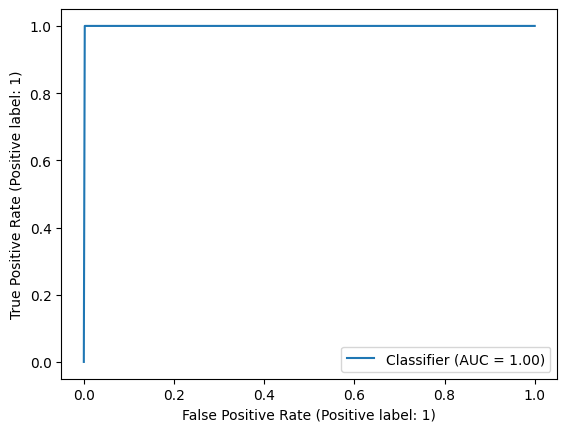

In [24]:
# Predictions
y_pred = grid_search.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
recall = recall_score(y_test, y_pred,pos_label=1) # Meilleure métrique car prend en compte également les faux négatifs.
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Affichage résultat Predictions

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Matrice de confusion",confusion_matrix(y_test, y_pred))
print("Recall:",recall)

fpr, tpr, thresholds = roc_curve(y_test, y_pred,pos_label=1)
print("False positive rate:", fpr)
print("True positive rate:", tpr)
print("Thresholds:", thresholds)

RocCurveDisplay.from_predictions(y_test, y_pred,pos_label=1)
print("Thresholds:", thresholds)
print("AUC: ", metrics.auc(fpr, tpr))


